# Application Deployment

This notebook demonstrates the end-to-end process of building, testing, and deploying a banking virtual assistant using MLRun, LangChain, and Milvus for vector storage. It covers project setup, data ingestion for retrieval-augmented generation, application graph definition with guardrails and analysis steps, local testing, and deployment to Kubernetes. An interactive Gradio UI is also provided for user testing and demonstration.

![](images/03_application_deployment_architecture.png)

In [ ]:
!pip install -r requirements.txt

In [1]:
import os
import mlrun
from langchain_milvus import Milvus
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv("ai_gateway.env")

True

### Setup Project

Load the previously created project in the first notebook.

In [2]:
project = mlrun.get_or_create_project("banking-agent", user_project=False)

Setting Source for the demo:
Project Source: None
> 2025-09-03 18:04:38,459 [info] Project loaded successfully: {"project_name":"banking-agent"}


This tutorial uses [Milvus](https://milvus.io/api-reference/pymilvus/v2.4.x/About.md) on a local host for simplicity. To use Milvus without the local host, see [Manage Milvus Connections](https://milvus.io/docs/v2.1.x/manage_connection.md)

In [3]:
MILVUS_ARGS = {"uri": f"{os.getcwd()}/milvus_demo.db"}
MILVUS_ARGS

{'uri': '/User/mlrun-banking-agent-demo/milvus_demo.db'}

### Ingest Data for Vector Store Retrieval

This section covers the ingestion of banking knowledge base documents into the Milvus vector store. By loading and embedding markdown files containing general bank information, account details, and customer FAQs, we enable efficient retrieval-augmented generation for the virtual assistant. The following steps demonstrate how to load, embed, and store these documents for downstream use in the application.

In [4]:
vectorstore = Milvus(
    collection_name="banking_agent",
    embedding_function=OpenAIEmbeddings(model="text-embedding-3-small"),
    connection_args=MILVUS_ARGS,
    auto_id=True,
)

In [5]:
if not vectorstore.col:
    general_bank_info_kb = UnstructuredMarkdownLoader(
        "data/general_bank_info_kb.md"
    ).load()
    checking_savings_kb = UnstructuredMarkdownLoader(
        "data/checking_savings_kb.md"
    ).load()
    customer_faq = UnstructuredMarkdownLoader("data/customer_faq.md").load()
    pages = general_bank_info_kb + checking_savings_kb + customer_faq
    vectorstore.add_documents(pages)

In [6]:
vectorstore.col.num_entities

3

In [7]:
# vectorstore.col.drop()

### Define Application Serving Graph

The application serving graph orchestrates the flow of user queries through a series of modular steps:

- **Input Guardrails:**  
    Ensure only safe and relevant queries proceed by filtering out inappropriate or off-topic inputs.

- **Sentiment & Churn Analysis:**  
    Analyze user sentiment and predict churn propensity to enrich the context for downstream processing.

- **Context Building:**  
    Aggregate user information, sentiment, and churn data to construct a detailed context for the agent.

- **Response Generation:**  
    The agent leverages the built context and retrieval-augmented generation from the vector store to provide accurate and personalized responses.

This **graph-based architecture** enables robust, explainable, and extensible deployment of the banking virtual assistant, ensuring each step is modular and transparent for easier maintenance and future enhancements.

See real-time serving graphs in the [documentation](https://docs.mlrun.org/en/stable/serving/serving-graph.html) for more information.

In [58]:
banking_topic_guardail = project.get_function("banking-topic-guardrail-v2")
toxicity_guardrail = project.get_function("toxicity-guardrail")
churn_model = project.get_function("serving")

In [59]:
from pathlib import Path

In [60]:
requirements = Path("requirements.txt").read_text().split()

In [61]:
agent_graph = project.set_function(
    name="banking-agent",
    func="src/functions/agent_graph_v2.py",
    kind="serving",
    image="mlrun/mlrun",
    # requirements_file="requirements.txt",
)
agent_graph.spec.build.with_commands(
    commands=[
        f'pip install --index-url https://download.pytorch.org/whl/cpu --extra-index-url https://pypi.org/simple {" ".join(requirements)}'
    ],
    overwrite=True
)
# Mount storage for vector store
# Should use client/server architecture in production
agent_graph.apply(mlrun.auto_mount())

In [ ]:
graph = agent_graph.set_topology("flow", engine="async", exist_ok=True)
guardrails_router = graph.add_step(
    "*ParallelRunMerger",
    name="input-guardrails",
    output_key="guardrails_output",
    extend_event=True,
)

guardrails_router.add_route(
    key="banking-topic-guardrail",
    class_name="mlrun.serving.remote.RemoteStep",
    method="POST",
    url=banking_topic_guardail.get_url(),
)
guardrails_router.add_route(
    key="toxicity-guardrail",
    class_name="mlrun.serving.remote.RemoteStep",
    method="POST",
    url=toxicity_guardrail.get_url(),
)
graph.add_step(
    name="guardrail-filter",
    class_name="GuardrailsChoice",
    mapping={"True": "accept", "False": "reject"},
    after="input-guardrails",
)
graph.add_step(name="accept", handler="accept", after="guardrail-filter")

input_analysis_router = graph.add_step(
    "*ParallelRunMerger",
    name="input-analysis",
    output_key="input_analysis_output",
    after="accept",
    extend_event=True,
)
input_analysis_router.add_route(
    key="sentiment-analysis",
    class_name="SentimentAnalysisModelServer",
    result_path="sentiment_analysis_output",
)
input_analysis_router.add_route(
    key="churn-prediction",
    class_name="ChurnModelServer",
    dataset="store://datasets/banking-agent/data-process-data_test#0:latest",
    label_column="churn",
    endpoint_url=project.get_function('serving', tag='latest').get_url(),
    churn_mappings={"high": 0.50, "medium": 0.20, "low": 0},
    result_path="churn_model_output",
)

graph.add_step(
    name="build-context",
    class_name="BuildContext",
    context_mappings={
        "name": "name",
        "sentiment": 'input_analysis_output."sentiment-analysis".outputs[0]',
        "churn": 'input_analysis_output."churn-prediction".outputs[0]',
    },
    output_key="formatted_prompt",
    prompt="""
    This is context about the user and their query:
    <user_context>
    name: {name}
    sentiment: {sentiment}
    churn propensity percentage: {churn}
    </user_context>

    If they have a high churn propensity consider asking them if would like to escalate to a human operator.
    Do not offer to escalate for low churn propensity.
    Do NOT mention the churn propensity but use it to craft your response.
    Use the sentiment to craft your response.
    """,
    after="input-analysis",
)
graph.add_step(
    name="banking-agent",
    class_name="BankingAgent",
    model_name="gpt-4o-mini",
    system_prompt="You are a helpful assistant for IGZ Bank. Respond in a concise, but detailed way. Use web search if the customer asks about other banks or external information.",
    result_path="banking-agent",
    after="build-context",
    prompt_input_key="formatted_prompt",
    messages_input_key="inputs",
    vector_db_collection="banking_agent",
    vector_db_args=MILVUS_ARGS,
    vector_db_description="Use this to answer any questions about general bank info like locations, hours, guidelines for opening savings/checking accounts, APY for savings/checking, as well as general FAQ like resetting passowrds, ATM fees, setting up direct deposit, etc.",
)
graph.add_step(name="reject", handler="reject", after="guardrail-filter")

graph.add_step(
    name="output", handler="responder", after=["banking-agent", "reject"]
).respond()

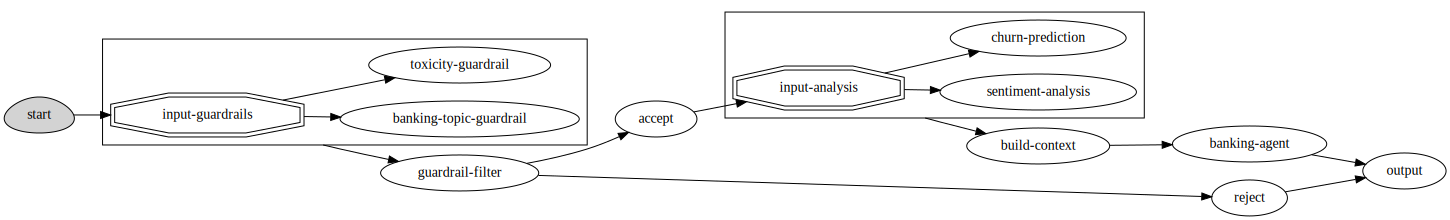

In [31]:
graph.plot(rankdir="LR")

In [26]:
mock = agent_graph.to_mock_server()

> 2025-09-03 19:56:56,962 [info] Loaded ['banking-topic-guardrail', 'toxicity-guardrail']


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


> 2025-09-03 19:56:57,910 [info] model sentiment-analysis was loaded
> 2025-09-03 19:56:57,992 [info] model churn-prediction was loaded
> 2025-09-03 19:56:57,993 [info] Loaded ['sentiment-analysis', 'churn-prediction']
Establishing connection to OpenAI
> 2025-09-03 19:56:58,041 [info] model banking-agent was loaded


In [13]:
HIGH_PROPENSITY_CHURN_USER_ID = 32
LOW_PROPENSITY_CHURN_USER_ID = 2296

### Test Input Guardrails

In [14]:
def _format_question(question: str, role: str = "user"):
    return {"role": role, "content": question}

Question the agent CANNOT answer - rejects input

In [15]:
resp = mock.test(
    path="/",
    body={
        "name": "John",
        "inputs": [_format_question("how to make hot dogs?")],
        "user_id": LOW_PROPENSITY_CHURN_USER_ID,
    },
)
print(resp["outputs"][0])

As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?


Question the agent CANNOT answer - rejects input

In [16]:
resp = mock.test(
    path="/",
    body={
        "name": "John",
        "inputs": [_format_question("i hate you")],
        "user_id": LOW_PROPENSITY_CHURN_USER_ID,
    },
)
print(resp["outputs"][0])

As a banking agent, I am not allowed to talk on this subject. Is there anything else I can help with?


### Test Banking Agent - Sentiment Analysis + Churn Propensity

Standard Q&A with neutral sentiment and low churn

In [17]:
resp = mock.test(
    path="/",
    body={
        "name": "John",
        "inputs": [_format_question("how to apply for checking account?")],
        "user_id": LOW_PROPENSITY_CHURN_USER_ID,
    },
)
print(resp["banking-agent"]["outputs"]["response"][0])

To apply for a checking account with IGZ Bank, follow these steps:

### Eligibility Requirements:
1. Must be 18 years or older.
2. Provide a valid government-issued photo ID (e.g., driver's license, passport).
3. Social Security Number (SSN) or Taxpayer Identification Number (TIN).

### Required Documents:
- Proof of address (such as a utility bill or lease agreement) dated within the last 60 days.
- An initial deposit (minimum $50 for checking accounts).

### Account Options:
1. **Basic Checking**: 
   - Monthly fee: $5 (waived with a balance of $500+)
   - APY: 0.01%
2. **Rewards Checking**:
   - Monthly fee: $10
   - Cash back: Up to 1.5% on debit card purchases, APY: 0.10%

### Application Process:
- **Online**: Fill out the application form, upload the required documents, and e-sign the agreement.
- **In-Branch**: Complete a paper form and present the necessary documents to a representative.

### Account Activation:
- **Online Applications**: Instant activation; your debit card wi

Standard Q&A with negative sentiment and low churn

In [18]:
resp = mock.test(
    path="/",
    body={
        "name": "John",
        "inputs": [
            _format_question(
                "how to apply for checking account? I keep trying but I'm really frustrated"
            )
        ],
        "user_id": LOW_PROPENSITY_CHURN_USER_ID,
    },
)
print(resp["banking-agent"]["outputs"]["response"][0])

I understand that applying for a checking account can be frustrating. Here’s how you can apply, step by step:

### Eligibility Requirements
- You must be 18 years or older.
- Have a valid government-issued photo ID (like a driver’s license or passport).
- Provide your Social Security Number (SSN) or Taxpayer Identification Number (TIN).

### Required Documents
- Proof of address (such as a utility bill or lease agreement) dated within the last 60 days.
- An initial deposit (at least $50 for checking accounts).

### Application Process
1. **Online Application:**
   - Visit our website and fill out the online application form.
   - Upload the necessary documents.
   - E-sign the agreement.
   - Your account could be activated instantly.

2. **In-Branch Application:**
   - You can also visit a branch and complete a paper form.
   - Present the required documents to a representative.
   - Your account will be activated immediately, and you’ll receive your debit card on the spot.

If you're

Standard Q&A with low sentiment and high churn - note that the model offers to escalate to a human operator. This kind of behavior is customizable depending on the input guardrails and input analysis.

In [19]:
resp = mock.test(
    path="/",
    body={
        "name": "Alice",
        "inputs": [
            _format_question(
                "how to apply for checking account? I keep trying but I'm really frustrated"
            )
        ],
        "user_id": HIGH_PROPENSITY_CHURN_USER_ID,  # <-- High churn propensity user
    },
)
print(resp["banking-agent"]["outputs"]["response"][0])

I understand that applying for a checking account has been frustrating for you. Here's a clear breakdown of the process to help you get started:

### Eligibility Requirements
- Must be **18 years or older**.
- A **valid government-issued photo ID** (like a driver's license or passport).
- Your **Social Security Number (SSN)** or **Taxpayer Identification Number (TIN)**.

### Required Documents
- Proof of address (such as a utility bill or lease agreement) dated within the last **60 days**.
- An **initial deposit**: at least **$50** for checking accounts.

### Application Process
1. **Online:**
   - Fill out the application form.
   - Upload the required documents.
   - E-sign the agreement.

2. **In-branch:**
   - Complete a paper application form.
   - Present the required documents to a representative.

### Account Activation
- **Online applications:** Typically involve instant activation, and your debit card will be mailed within **5–7 business days**.
- **In-branch applications:** 

Standard multi-turn Q&A

In [20]:
resp = mock.test(
    path="/",
    body={
        "name": "Alice",
        "inputs": [
            {"role": "user", "content": "Hi—how do I open a checking account?"},
            {
                "role": "assistant",
                "content": "To open a checking account, you need two forms of ID and a minimum deposit of $25.",
            },
            {"role": "user", "content": "Is it possible to get cashback rewards?"},
        ],
        "user_id": HIGH_PROPENSITY_CHURN_USER_ID,  # <-- High churn propensity user
    },
)
print(resp["banking-agent"]["outputs"]["response"][0])

Yes, IGZ Bank offers a Rewards Checking account that provides cashback rewards of up to 1.5% on debit card purchases. The monthly fee for this account is $10, which can be waived if you maintain a certain balance.

If you're interested in opening this account or need more information, feel free to ask!


### Full Outputs

Below is the comprehensive output from the application graph. This includes all intermediate and final results: user input, guardrails decisions, input analysis (such as sentiment and churn predictions), any tool calls, and the generated response from the model. Use this section to trace the end-to-end flow and understand how each component contributes to the final answer.

In [21]:
resp

{'name': 'Alice',
 'inputs': [{'role': 'user',
   'content': 'Hi—how do I open a checking account?'},
  {'role': 'assistant',
   'content': 'To open a checking account, you need two forms of ID and a minimum deposit of $25.'},
  {'role': 'user', 'content': 'Is it possible to get cashback rewards?'}],
 'user_id': 32,
 'background_task_state': failed,
 'guardrails_output': {'toxicity-guardrail': {'id': '6ee85a71-8ce0-4e83-8ec6-016a5d58d403',
   'model_name': 'toxicity-guardrail',
   'outputs': [True],
   'timestamp': '2025-09-03 18:05:46.848080+00:00',
   'model_endpoint_uid': '42e8695886f646799909b2db878e093e'},
  'banking-topic-guardrail': {'id': '376657b6-a8d0-4db3-9d3f-9701842766d0',
   'model_name': 'banking-topic-guardrail',
   'outputs': ['True'],
   'timestamp': '2025-09-03 18:05:46.847962+00:00',
   'model_endpoint_uid': '9416e315ed944fdb9c00be4cbdab1e15'}},
 'input_analysis_output': {'churn-prediction': {'id': '5b9f1786869e4d0eb0d8fc59afaea517',
   'model_name': 'churn-predicti

### Deploy to K8s

Deploy the banking agent application to a production-ready Kubernetes endpoint. This enables robust, scalable, and highly available access for integration with real-world applications. Kubernetes orchestration ensures automatic scaling and reliability based on demand.

In [63]:
project.deploy_function(agent_graph)

> 2025-09-03 21:18:41,985 [info] Starting remote function deploy
2025-09-03 21:18:42  (info) Deploying function
2025-09-03 21:18:42  (info) Building
2025-09-03 21:18:43  (info) Staging files and preparing base images
2025-09-03 21:18:43  (warn) Using user provided base image, runtime interpreter version is provided by the base image
2025-09-03 21:18:43  (info) Building processor image
2025-09-03 21:22:43  (info) Build complete
2025-09-03 21:23:59  (info) Function deploy complete
> 2025-09-03 21:24:04,932 [info] Model endpoint creation task completed with state succeeded
> 2025-09-03 21:24:04,933 [info] Successfully deployed function: {"external_invocation_urls":["banking-agent-banking-agent.default-tenant.app.cst-360.iguazio-cd0.com/"],"internal_invocation_urls":["nuclio-banking-agent-banking-agent.default-tenant.svc.cluster.local:8080"]}


DeployStatus(state=ready, outputs={'endpoint': 'http://banking-agent-banking-agent.default-tenant.app.cst-360.iguazio-cd0.com/', 'name': 'banking-agent-banking-agent'})

In [64]:
resp = agent_graph.invoke(
    path="/",
    body={
        "name": "Alice",
        "inputs": [
            {"role": "user", "content": "Hi—how do I open a checking account?"},
            {
                "role": "assistant",
                "content": "To open a checking account, you need two forms of ID and a minimum deposit of $25.",
            },
            {"role": "user", "content": "Is it possible to get cashback rewards?"},
        ],
        "user_id": HIGH_PROPENSITY_CHURN_USER_ID,  # <-- High churn propensity user
    },
)
print(resp["banking-agent"]["outputs"]["response"][0])

Yes, IGZ Bank offers a Rewards Checking account that provides cashback on debit card purchases. You'll earn up to 1.5% cashback, and the account comes with a monthly fee of $10. This fee can be waived if you maintain a balance of $500 or more.

If you're interested, you can open this account online or in-branch. Let me know if you need more information!


### Application UI

The Streamlit UI offers an interactive environment to test and explore the banking agent's capabilities. Its main features include:

- **Chat Window:**  
    Engage in a conversational interface where you can enter questions and receive responses from the assistant, simulating real user interactions.

- **Tool Usage Visualization:**  
    When the agent invokes external tools or APIs (such as retrieving information from the vector store), these actions are surfaced in the chat, allowing you to see when and how tools are used.

- **Intermediate Graph Steps:**  
    The UI displays outputs from key stages of the application graph, including:
    - **Input Guardrails:**  
        - *Toxicity Guardrail Passed* — Indicates if the input passes the toxicity filter.
        - *Banking Topic Guardrail Passed* — Shows whether the query is relevant to banking topics.
    - **Input Analysis:**  
        - *Sentiment Analysis* — Reveals the detected sentiment of the user's input.
        - *Churn Prediction* — Estimates the user's propensity to leave, which can influence the assistant's response.

This transparent design helps users trace the end-to-end flow of their queries, understand decision points, and gain insight into how each system component contributes to the final answer.

![](images/banking_agent_ui.png)

In [79]:
!tar -czvf frontend_ui.tar.gz ./src/functions/frontend_ui.py

I0000 00:00:1756935047.797779 1273114 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


./src/functions/frontend_ui.py


In [81]:
frontend_source = project.log_artifact("frontend_source", local_path="frontend_ui.tar.gz", upload=True)

In [82]:
ui_fn = project.set_function(
    name="frontend",
    kind="application",
    image="mlrun/mlrun",
    requirements=["streamlit==1.49.1"]
)

In [83]:
API_URL = agent_graph.get_url()
API_URL

'http://nuclio-banking-agent-banking-agent.default-tenant.svc.cluster.local:8080'

In [84]:
ui_fn.set_env("API_URL", API_URL)
ui_fn.with_source_archive(frontend_source.target_path, pull_at_runtime=False)
ui_fn.set_internal_application_port(8000)
ui_fn.spec.command = "streamlit"
ui_fn.spec.args = ["run", "--server.port", "8000", "/home/mlrun_code/src/functions/frontend_ui.py"]

In [ ]:
ui_fn.deploy(with_mlrun=False, create_default_api_gateway=False)
ui_fn.create_api_gateway(
    name="banking-agent-ui",
    path="/",
    direct_port_access=True,
    ssl_redirect=True,
    set_as_default=False,
    authentication_mode="none"
)